Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The zip file is unzipped in the drive

In [4]:
!unzip gdrive/My\ Drive/Colab\ Notebooks/CNN_assignment.zip

Archive:  gdrive/My Drive/Colab Notebooks/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  i

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(f'/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path(f'/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


There are 2239 Train data and 118 Testdata. Making the total of 2357 images of the skin types

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


The 80% of 2239 is 1792 images are taken for the subset as 'Training'

In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


The 20% of 2239 is 447 images are taken for the subset as 'Validation'. We are going to use this Train and Validation data for our further analysis

In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


All 9 class Names are listed.

'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

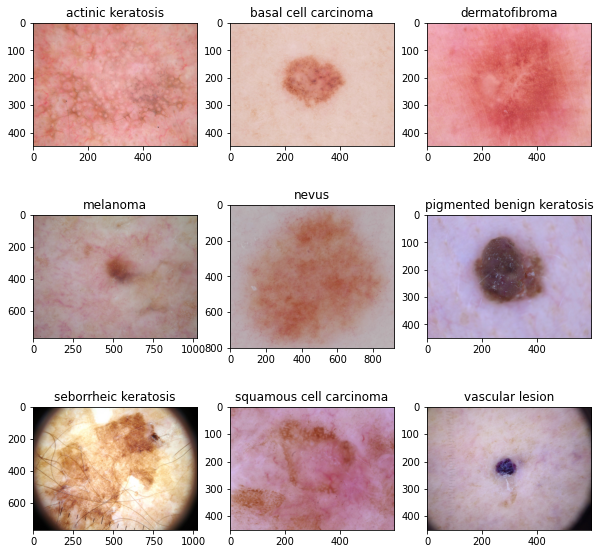

In [11]:
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

Each class 1 image is displayed with its label

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Sequential model is designed with the Rescaling as preprocessing and the different layers of Conv2D and MaxPool Layer are used.

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
from tensorflow.keras.optimizers import RMSprop

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

We have used the optimizer as 'adam' and loss as 'sparse categorical crossentrophy' since it is used for the multiple class

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 180, 180, 16)      1216      
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 90, 90, 16)        0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 90, 90, 32)        12832     
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 45, 45, 32)        0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 45, 45, 64)        51264     
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 22, 22, 64)        0

There are around 4 Lakh parameters will be used to train our model. Lets analyse our layers which we created is enough for the analysis

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 44s 75ms/step - loss: 2.0697 - accuracy: 0.1959 - val_loss: 2.0303 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 2.0096 - accuracy: 0.2243 - val_loss: 1.9914 - val_accuracy: 0.2550
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.9155 - accuracy: 0.2857 - val_loss: 1.9860 - val_accuracy: 0.2841
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.9355 - accuracy: 0.2679 - val_loss: 1.8464 - val_accuracy: 0.3110
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.8143 - accuracy: 0.3058 - val_loss: 1.8197 - val_accuracy: 0.3289
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.7686 - accuracy: 0.3410 - val_loss: 1.7083 - val_accuracy: 0.3490
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6840 - accuracy: 0.3912 - val_loss: 1.6760 - val_accuracy: 0.4072
Epoch 8/20
5

### Visualizing training results

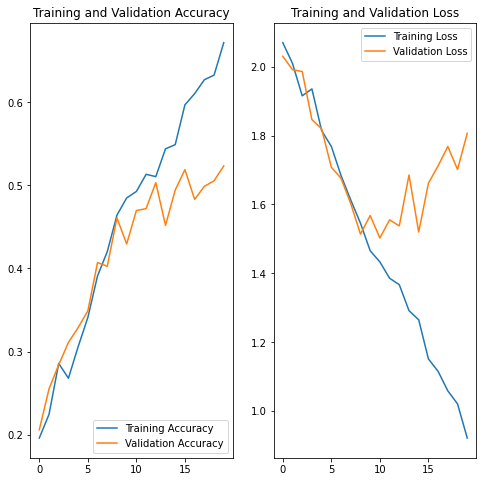

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

**The Findings in the Initial Findings are:**

- The model is overfitted because, when we observe the 20 epochs, we see that the validation loss increase after certain point upwards.
- Also we can notice that there is a difference in loss functions in Training and Validation as we near the end of the epoch.
- The Accuracy of the train is around 60% which is not bad for the initial run.

We might need to see in our further analysis.

We need to perform augmentation. Data augmentation is the technique which is used to increase the number of the images / the size of the data in the Training dataset.
To get the proper predictions without having the overfitting of the model, we need more data to be added. The existing Training data is augmented in order to make a better generalized model.

There are different types of augmentation which can be used categorized into Position Augmentation and Color Augmentation.

In our analysis, we will not use Color Augmentation. We will be using the Position Augmentation. 
Our model is not worried about the position of the disease, so we will use Flipping both horizontal and vertical , Rotation and Zoom.

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

Lets view the images 

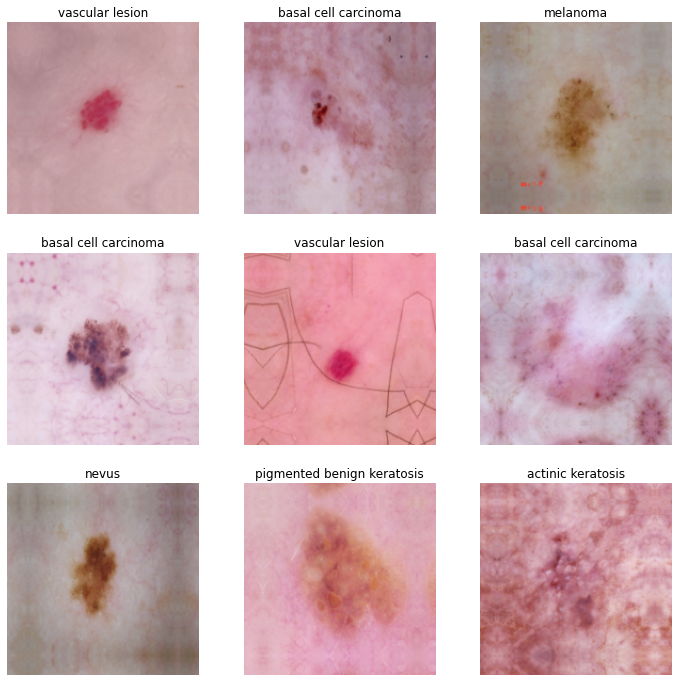

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


We create new model with the ssame set of the Conv2D Layer but with dropOut added

In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


Compile the Model

We will be using the same compile steps

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 34ms/step - loss: 2.0358 - accuracy: 0.2076 - val_loss: 1.9514 - val_accuracy: 0.2483
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.8907 - accuracy: 0.3086 - val_loss: 1.7196 - val_accuracy: 0.4094
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.6526 - accuracy: 0.4124 - val_loss: 1.6621 - val_accuracy: 0.4318
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5990 - accuracy: 0.4442 - val_loss: 1.6157 - val_accuracy: 0.4362
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5764 - accuracy: 0.4509 - val_loss: 1.6488 - val_accuracy: 0.4161
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5533 - accuracy: 0.4576 - val_loss: 1.6042 - val_accuracy: 0.4430
Epoch 7/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5998 - accuracy: 0.4386 - val_loss: 1.5725 - val_accuracy: 0.4899
Epoch 8/20
56

Although the loss is not increasing drastically, we can see the Accuracy has not increased. Our overfitting error is not present after augmenting the data

### Visualizing the results

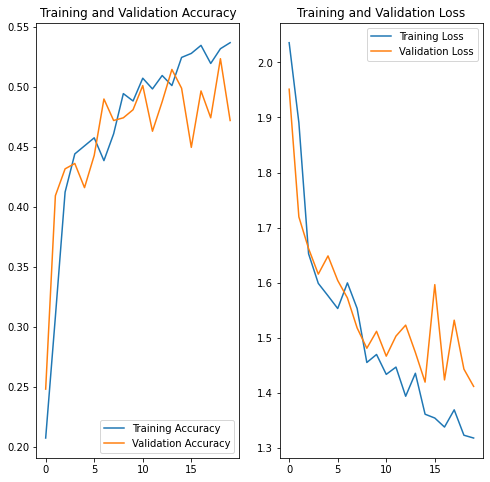

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The data is trained only for 20 epochs, we might not be able to tell clearly, but from the plot we can say that there is not much difference in loss between the Train and the Test data

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

We need to solve the Class Imbalance between the classes. Before performing any actions for it, We will create the Orignal_df dataframe which has the original images path and the label.

In [25]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


Distribution of the different Classes image count

<BarContainer object of 9 artists>

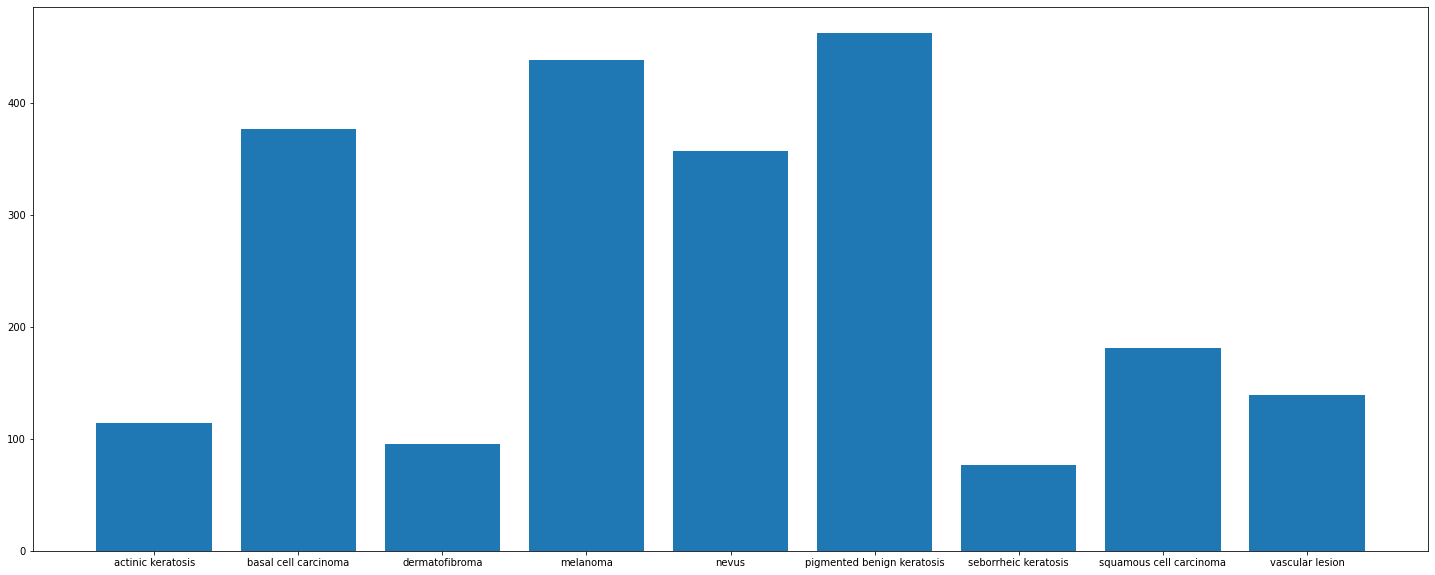

In [26]:
## Your code goes here.
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
####   -- ***Seborrheic keratosis*** is having the ***lowest*** distribution
#### - Which classes dominate the data in terms proportionate number of samples?
#### -- ***Pigmented Benign keratosis*** is having the **highest** distribution of data


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset= str(data_dir_train)+"/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7AFC30A150>: 100%|██████████| 500/500 [00:15<00:00, 32.68 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7AFA51A5D0>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7AFA51A390>: 100%|██████████| 500/500 [00:15<00:00, 32.41 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7AFA51FED0>: 100%|██████████| 500/500 [00:16<00:00, 30.84 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F7AFA714950>: 100%|██████████| 500/500 [01:33<00:00,  5.36 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=959x639 at 0x7F7AFA1D5E50>:   1%|          | 3/500 [00:00<01:28,  5.65 Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=576x768 at 0x7F7AFC5DCC10>: 100%|██████████| 500/500 [01:21<00:00,  6.15 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7B61EEC190>: 100%|██████████| 500/500 [00:15<00:00, 32.08 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F7AFC010750>:   0%|          | 1/500 [00:00<00:52,  9.58 Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F7AFC338390>: 100%|██████████| 500/500 [00:38<00:00, 13.02 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7AFA6E1590>: 100%|██████████| 500/500 [00:16<00:00, 31.06 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7AFC20F790>:   0%|          | 1/500 [00:00<00:54,  9.10 Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7AFC00CED0>: 100%|██████████| 500/500 [00:15<00:00, 31.49 Samples/s]


We have added extra 500 sample in the data so that we have enough records in each of the classes

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


The new data added is 4500. which is 500 sample data for each of the 9 classes.

The Train data is 2239. So the total data after the augmentation is 6739

### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
from glob import glob

In [31]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000171.jpg_6d98856c-8909-4594-979c-6335fe17c806.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000554.jpg_252c40c6-f7d4-424f-97ba-5ff64bc510c4.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011057.jpg_35ad3833-21a9-467e-924d-f3c33998c545.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000549.jpg_9ad1e497-0c2b-480a-9ee5-3c778c7dbe96.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010690.jpg_f4365b95-ded3-45e8-b58a-f4de51c2a40a.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011042.jpg_b8f09

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

New Augmented Data path and the image class name is taken

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [35]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [36]:
new_df['Path'].value_counts()

/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025470.jpg                                                                                        1
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029973.jpg_6cd40cb7-9777-4b73-917f-38e756e907bd.jpg                            1
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028568.jpg_611786b7-db2e-44fb-b754-73cf8f78d65a.jpg                1
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0024572.jpg                                                                                              1
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028376.

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [38]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


6739 Train data total present after augmenting 4500 images in all the classes.
80% of 6739 is 5392 taken as training data

#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


6739 Train data total present after augmenting 4500 images in all the classes.
20% of 6739 is 1347 taken as validation data

#### **Todo:** Create your model (make sure to include normalization)

In [40]:
## your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='softmax', input_shape = (180, 180, 32)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='softmax'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='softmax'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [41]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [42]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 29s 166ms/step - loss: 2.2341 - accuracy: 0.1213 - val_loss: 2.1990 - val_accuracy: 0.1151
Epoch 2/50
169/169 [==============================] - 28s 164ms/step - loss: 2.2209 - accuracy: 0.1335 - val_loss: 2.2107 - val_accuracy: 0.1359
Epoch 3/50
169/169 [==============================] - 28s 165ms/step - loss: 2.2256 - accuracy: 0.1330 - val_loss: 2.2423 - val_accuracy: 0.1403
Epoch 4/50
169/169 [==============================] - 29s 165ms/step - loss: 2.1927 - accuracy: 0.1495 - val_loss: 1.9441 - val_accuracy: 0.2576
Epoch 5/50
169/169 [==============================] - 28s 163ms/step - loss: 1.7681 - accuracy: 0.2941 - val_loss: 1.6641 - val_accuracy: 0.3660
Epoch 6/50
169/169 [==============================] - 28s 164ms/step - loss: 1.6312 - accuracy: 0.3726 - val_loss: 1.5863 - val_accuracy: 0.4046
Epoch 7/50
169/169 [==============================] - 28s 162ms/step - loss: 1.5420 - accuracy: 0.4069 - val_loss: 1.5112 - val_ac

We have ran 50 epochs, since 20 epochs is small for training.
We have got an Train accuracy of 89% and validation accuracy of 80%.
Above 80% accuracy is good model without hyperparameter tuning.

#### **Todo:**  Visualize the model results

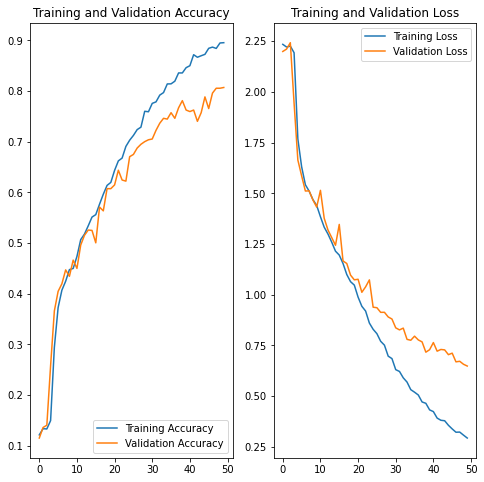

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1. When we added the Augmentor for the solving the class imbalance, we have enough data added in all the classes. It has improved the accuracy and the training validation loss has reduced.
2. We havent done any hyperparameter tuning. When we perform hyper-parameter, we can get better results in the accuracy.
3. With Augmentation alone we have achieved more than 89% accuracy in Training and 80% in Validation. Its a good model. If we can run with hyperparameter tuned model and the higher epochs, we might still get more accuracy and very good model.